# Streamlines and velocity fields for axis-symmetric bubbles

Six bubbles are investigated:
- bubbles in aqueous sugar solutions (Bhaga & Weber 1981)
    - dimpled ellipsoidal $Eo=243$, $Mo=266$, $Ga^\prime=80$
    - spherical cap (closed wake) $Eo=115$, $Mo=4.63\times 10^{-3}$, $Ga^\prime = 135$
    - skirted (smooth) $Eo = 339$, $Mo=43.1$, $Ga^\prime = 30.8$
- small bubbles in water at 20°C, $Mo=2.5728\times 10^{-11}$
    - $d_{eq}=1.0~mm$ corresponding to $Eo=0.1346$, $Ga^\prime = 98.672$
    - $d_{eq}=1.4~mm$ corresponding to $Eo=0.2638$, $Ga^\prime = 163.45$
    - $d_{eq}=1.8~mm$ corresponding to $Eo=0.4361$, $Ga^\prime = 238.29$
  
The velocity fields are extracted from the Basilisk simulations using Paraview. The steps are:

- open the right time step: note that there is in offset of 1 between the time displayed in paraview and the physical time because the output files start at t=1 (the physical time t=0 will be displayed as t=0 in paraview)
- transform filter: rotate 90° around z axis to swap x and y axis
- reflect filter: reflect at *X Max* and copy the input (checkbox *Copy Input*)
- cell centers filter
- go to *File* -> *Save Data ...*; select a file name; set the precission to 15 and select *Points* as field association; save

In [163]:
import glob

data_path = "./data/"
files = sorted(glob.glob(data_path + "*"))
print(files)

['./data/bhaga_02_l16_t30.csv', './data/bhaga_03_l16_t30.csv', './data/bhaga_04_l16_t20.csv', './data/water_01_l16_t12.csv', './data/water_03_l16_t14.csv', './data/water_05_l16_t14.csv']


In [164]:
import pandas as pd
import numpy as np
import matplotlib.tri as tri

class Velocity():
    def __init__(self, path=None, center=None, u_b=None, ga=None):
        self.path = path
        self.center = center
        self.u_b = u_b
        self.ga = ga
        self.read_from_disk()
        self.triang = None
        self.interpolator_u_x = None
        self.interpolator_u_y = None
        self.interpolator_f = None
        
        
    def read_from_disk(self):
        names = ['f', 'ref', 'u_x', 'u_y', 'u_z', 'x', 'y', 'z']
        usecols = ['f', 'u_x', 'u_y', 'x', 'y']
        try:
            self.data = pd.read_csv(self.path, sep=',', header=0, names=names, usecols=usecols)
        except Exception as read_exc:
            print("Error reading data from disk for file \033[1m{}\033[0m".format(self.path))
            
    
    def create_triangulation(self):
        self.triang = tri.Triangulation(self.data['x'].values, self.data['y'].values-self.center)
    
    
    def get_reynolds(self, xi, yi, relative=False, magnitude=True):
        # create triangulation
        if self.triang is None: self.create_triangulation()
                        
        if (self.interpolator_u_x is None) or (self.interpolator_u_y is None):
            self.interpolator_u_x = tri.CubicTriInterpolator(self.triang, self.data['u_x'].values, kind='geom')
            self.interpolator_u_y = tri.CubicTriInterpolator(self.triang, self.data['u_y'].values, kind='geom')
            
        u_x_i = self.interpolator_u_x(xi, yi)
        u_y_i = self.interpolator_u_y(xi, yi)
        
        if relative:
            u_x_i -= self.u_b
            
        u_x_i *= self.ga
        u_y_i *= self.ga
            
        if magnitude:
            return np.sqrt(np.square(u_x_i) + np.square(u_y_i))
        else:
            return u_y_i, u_x_i # paraview bug: the transform filter does not swap the vector components
        
    def get_volume_fraction(self, xi, yi):
        # create triangulation
        if self.triang is None: self.create_triangulation()
            
        if self.interpolator_f is None:
            self.interpolator_f = tri.CubicTriInterpolator(self.triang, self.data['f'].values, kind='geom')
        
        return self.interpolator_f(xi, yi)

#times = [30, 30, 20, 12, 14, 14] # Basilisk simulation time
bubble_centers = [19.57088588, 25.93888942, 15.87381194, 34.28257266, 41.86696306, 38.27362914]
bubble_velocities = [0.54874959, 0.78901010, 0.63062704, 2.93135279, 3.07036012, 2.76750992]
ga = [15.2400, 134.626, 30.8340, 98.6715, 163.450, 238.287]
        
bhaga_02 = Velocity(files[0], center=bubble_centers[0], u_b=bubble_velocities[0], ga=ga[0]) # t=30
bhaga_03 = Velocity(files[1], center=bubble_centers[1], u_b=bubble_velocities[1], ga=ga[1]) # t=30
bhaga_04 = Velocity(files[2], center=bubble_centers[2], u_b=bubble_velocities[2], ga=ga[2]) # t=20
water_01 = Velocity(files[3], center=bubble_centers[3], u_b=bubble_velocities[3], ga=ga[3]) # t=12
water_03 = Velocity(files[4], center=bubble_centers[4], u_b=bubble_velocities[4], ga=ga[4]) # t=14
water_05 = Velocity(files[5], center=bubble_centers[5], u_b=bubble_velocities[5], ga=ga[5]) # t=14

all_fields = [bhaga_02, bhaga_03, bhaga_04, water_01, water_03, water_05]

In [165]:
# some figure preferences
nx = 200
ny = 400
alpha_contour = 0.75
lw_frac = 2.0
fontsize_contour = 14.0
fontsize_ticks = 18.0
fontsize_labels = 22.0

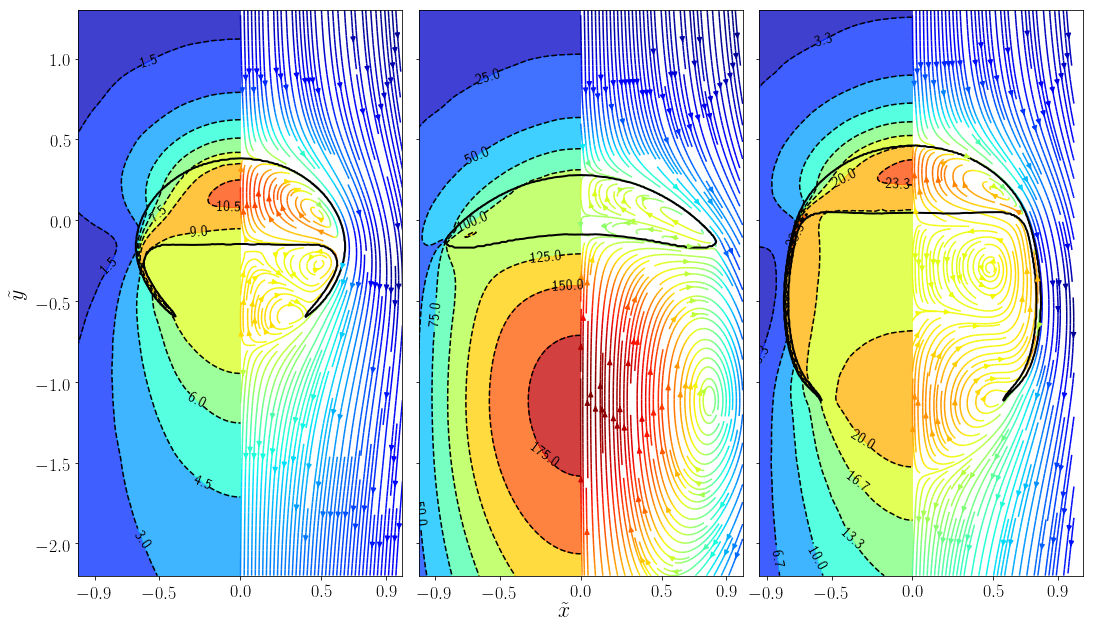

In [255]:
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

rc('text', usetex=True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(18, 10.4))

# bhaga
xi_right = np.linspace(0.0, 1.0, nx)
xi_left = np.linspace(-1.0, 0.0, nx)
xi_full = np.linspace(-1.0, 1.0, 2*nx)
yi = np.linspace(-2.2, 1.3, ny)
Xi_left, Yi_left = np.meshgrid(xi_left, yi)
Xi_right, Yi_right = np.meshgrid(xi_right, yi)
Xi_full, Yi_full = np.meshgrid(xi_full, yi)

# bhaga_02
ax1.contourf(xi_left, yi, bhaga_02.get_reynolds(Xi_left, Yi_left), cmap='jet', alpha=alpha_contour)
ax1_contour = ax1.contour(xi_left, yi, bhaga_02.get_reynolds(Xi_left, Yi_left), colors='black')
ax1.clabel(ax1_contour, inline=True, fontsize=fontsize_contour, fmt='%1.1f')
U_x_i, U_y_i = bhaga_02.get_reynolds(Xi_right, Yi_right, relative=True, magnitude=False)
stream = ax1.streamplot(Xi_right, Yi_right, U_x_i, U_y_i, color=bhaga_02.get_reynolds(Xi_right, Yi_right), cmap='jet', density=(1.5, 3.0), minlength=0.1, maxlength=8.0)
ax1.contour(xi_full, yi, bhaga_02.get_volume_fraction(Xi_full, Yi_full), levels=[0.5], colors=['k'], linewidths=lw_frac)

# bhaga_03
ax2.contourf(xi_left, yi, bhaga_03.get_reynolds(Xi_left, Yi_left), cmap='jet', alpha=alpha_contour)
ax2_contour = ax2.contour(xi_left, yi, bhaga_03.get_reynolds(Xi_left, Yi_left), colors='black')
ax2.clabel(ax2_contour, inline=True, fontsize=fontsize_contour, fmt='%1.1f')
U_x_i, U_y_i = bhaga_03.get_reynolds(Xi_right, Yi_right, relative=True, magnitude=False)
stream = ax2.streamplot(Xi_right, Yi_right, U_x_i, U_y_i, color=bhaga_03.get_reynolds(Xi_right, Yi_right), cmap='jet',
                        density=(1.5, 3.0), minlength=0.1, maxlength=8.0)
ax2.contour(xi_full, yi, bhaga_03.get_volume_fraction(Xi_full, Yi_full), levels=[0.5], colors=['k'], linewidths=lw_frac)

# bhaga_04
ax3.contourf(xi_left, yi, bhaga_04.get_reynolds(Xi_left, Yi_left), cmap='jet', alpha=alpha_contour, levels=np.linspace(0.0, 30.0, 10))
ax3_contour = ax3.contour(xi_left, yi, bhaga_04.get_reynolds(Xi_left, Yi_left), colors='black', levels=np.linspace(0.0, 30.0, 10))
ax3.clabel(ax3_contour, inline=True, fontsize=fontsize_contour, fmt='%1.1f')
U_x_i, U_y_i = bhaga_04.get_reynolds(Xi_right, Yi_right, relative=True, magnitude=False)
stream = ax3.streamplot(Xi_right, Yi_right, U_x_i, U_y_i, color=bhaga_04.get_reynolds(Xi_right, Yi_right), cmap='jet',
                        density=(1.5, 3.0), minlength=0.1, maxlength=8.0)
ax3.contour(xi_full, yi, bhaga_04.get_volume_fraction(Xi_full, Yi_full), levels=[0.5], colors=['k'], linewidths=lw_frac)

for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.label_outer()
    ax.set_xticks([-0.9,-0.5, 0.0, 0.5, 0.9])
    ax.tick_params(labelsize=fontsize_ticks)

for contour in [ax1_contour, ax2_contour, ax3_contour]:
    for line in contour.collections:
        line.set_linestyle('dashed')

fig.subplots_adjust(wspace=0.05)
fig.text(0.5, 0.07, r"$\tilde{x}$", ha='center', fontsize=fontsize_labels)
fig.text(0.07, 0.5, r"$\tilde{y}$", va='center', rotation='vertical', fontsize=fontsize_labels)
plt.savefig('bhaga_velocity.png', bbox_inches='tight')
plt.savefig('bhaga_velocity.pdf', bbox_inches='tight')
plt.show()

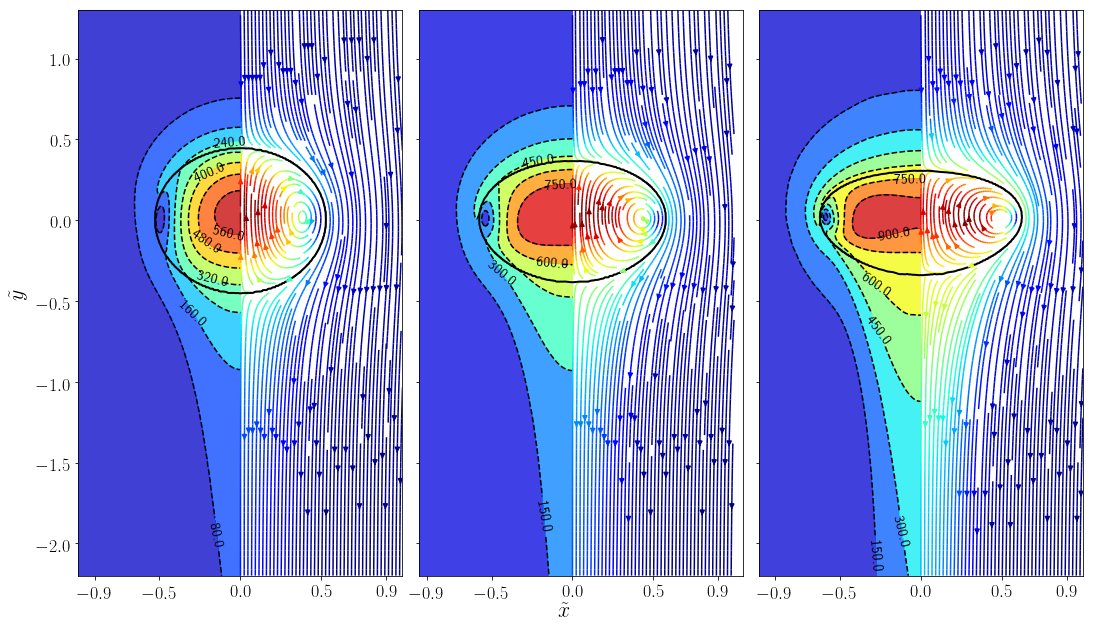

In [256]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(18, 10.4))

# water
xi_right = np.linspace(0.0, 1.0, nx)
xi_left = np.linspace(-1.0, 0.0, nx)
xi_full = np.linspace(-1.0, 1.0, 2*nx)
yi = np.linspace(-2.2, 1.3, ny)
Xi_left, Yi_left = np.meshgrid(xi_left, yi)
Xi_right, Yi_right = np.meshgrid(xi_right, yi)
Xi_full, Yi_full = np.meshgrid(xi_full, yi)

# water_01 (d_eq=1mm)
ax1.contourf(xi_left, yi, water_01.get_reynolds(Xi_left, Yi_left), cmap='jet', alpha=alpha_contour)
ax1_contour = ax1.contour(xi_left, yi, water_01.get_reynolds(Xi_left, Yi_left), colors='black')
ax1.clabel(ax1_contour, inline=True, fontsize=fontsize_contour, fmt='%1.1f')
U_x_i, U_y_i = water_01.get_reynolds(Xi_right, Yi_right, relative=True, magnitude=False)
stream = ax1.streamplot(Xi_right, Yi_right, U_x_i, U_y_i, color=water_01.get_reynolds(Xi_right, Yi_right), cmap='jet',
                        density=(1.5, 3.0), minlength=0.1, maxlength=8.0)
ax1.contour(xi_full, yi, water_01.get_volume_fraction(Xi_full, Yi_full), levels=[0.5], colors=['k'], linewidths=lw_frac)

# water_03 (d_eq=1.4mm)
ax2.contourf(xi_left, yi, water_03.get_reynolds(Xi_left, Yi_left), cmap='jet', alpha=alpha_contour)
ax2_contour = ax2.contour(xi_left, yi, water_03.get_reynolds(Xi_left, Yi_left), colors='black')
ax2.clabel(ax2_contour, inline=True, fontsize=fontsize_contour, fmt='%1.1f')
U_x_i, U_y_i = water_03.get_reynolds(Xi_right, Yi_right, relative=True, magnitude=False)
stream = ax2.streamplot(Xi_right, Yi_right, U_x_i, U_y_i, color=water_03.get_reynolds(Xi_right, Yi_right), cmap='jet',
                        density=(1.5, 3.0), minlength=0.1, maxlength=8.0)
ax2.contour(xi_full, yi, water_03.get_volume_fraction(Xi_full, Yi_full), levels=[0.5], colors=['k'], linewidths=lw_frac)

# water_05 (d_eq=1.8mm)
ax3.contourf(xi_left, yi, water_05.get_reynolds(Xi_left, Yi_left), cmap='jet', alpha=alpha_contour)
ax3_contour = ax3.contour(xi_left, yi, water_05.get_reynolds(Xi_left, Yi_left), colors='black')
ax3.clabel(ax3_contour, inline=True, fontsize=fontsize_contour, fmt='%1.1f')
U_x_i, U_y_i = water_05.get_reynolds(Xi_right, Yi_right, relative=True, magnitude=False)
stream = ax3.streamplot(Xi_right, Yi_right, U_x_i, U_y_i, color=water_05.get_reynolds(Xi_right, Yi_right), cmap='jet',
                        density=(1.5, 3.0), minlength=0.1, maxlength=8.0)
ax3.contour(xi_full, yi, water_05.get_volume_fraction(Xi_full, Yi_full), levels=[0.5], colors=['k'], linewidths=lw_frac)

for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.label_outer()
    ax.set_xticks([-0.9,-0.5, 0.0, 0.5, 0.9])
    ax.tick_params(labelsize=fontsize_ticks)

for contour in [ax1_contour, ax2_contour, ax3_contour]:
    for line in contour.collections:
        line.set_linestyle('dashed')

fig.subplots_adjust(wspace=0.05)
fig.text(0.5, 0.07, r"$\tilde{x}$", ha='center', fontsize=fontsize_labels)
fig.text(0.07, 0.5, r"$\tilde{y}$", va='center', rotation='vertical', fontsize=fontsize_labels)
plt.savefig('water_velocity.png', bbox_inches='tight')
plt.show()

# Extraction of tangential interface velocity

The aim is to extract the tangential interface velocity from pseudo 3D (axis-symmetric 2D) VoF simulations. The interface velocity is then used to create a more realistic velocity boundary condition for single phase simulations of rising bubbles, which is necessary to account for the induced shear stress due to the internal motion of the bubble (which otherwise would be missing, e.g., when using a free-slip boundary condition instead). The steps to extract the interface velocity and to create a machine learning model for the boundary are:

* load the PLIC planes and the velocity field
* compute the center of each PLIC plane
* interpolate the velocity vector field to the PLIC center points
* compute the unit normal vector for each PLIC plane
* decompose the velocity vector in tangential and normal contribution (with respect to each plane)
* train a MLP that takes the polar angle as features and returns the tangential velocity vector as label

In [166]:
import pickle
import os

class PlicCollection():
    def __init__(self, path, bubble_center, fields, flipXY=False, moveOriginBottom=False):
        self.path = path
        self.bubble_center = bubble_center
        self.fields = fields
        self.flipXY = flipXY
        self.moveOriginBottom = moveOriginBottom
        self.read_plic()
        self.compute_centers()
        self.compute_unit_normals()
        self.compute_polar_coordinates()
        
    def read_plic(self):
        assert os.path.isfile(self.path), "File {} does not exist.".format(self.path)
        file = open(self.path, 'rb')
        self.data = pickle.load(file)
        file.close()
        self.data.drop(["element"], axis=1, inplace=True)
        if self.flipXY:
            self.data.rename(columns={"px":"py", "py":"px"}, inplace=True)
        if self.moveOriginBottom:
            self.min_y = np.min(self.data.py.values)
            self.data["py"] = self.data.py.values - self.min_y
        else:
            self.data["py"] = self.data.py.values - self.bubble_center
        self.plic_elements = np.asarray([[(self.data.px.values[e], self.data.py.values[e]), (self.data.px.values[e+1], self.data.py.values[e+1])]
                   for e in range(0, self.data.shape[0]-1, 2)])
        
    def get_plic_elements(self):
        return self.plic_elements
        
    def compute_centers(self):
        self.plic_centers = np.zeros((self.plic_elements.shape[0], 2))
        for i, p12 in enumerate(self.plic_elements):
            p1, p2 = p12
            self.plic_centers[i] = 0.5 * (p1 + p2)
            
    def get_centers(self):
        return self.plic_centers
    
    def compute_unit_normals(self):
        self.unit_normals = np.zeros((self.plic_elements.shape[0], 2))
        for i, p12 in enumerate(self.plic_elements):
            p1, _ = p12
            diff = p1 - self.plic_centers[i]
            normal = np.asarray([diff[1], -diff[0]])
            ref_plus = self.plic_centers[i] + normal
            ref_min = self.plic_centers[i] - normal
            if self.moveOriginBottom:
                ref_plus[1] = ref_plus[1] + self.min_y - self.bubble_center
                ref_min[1] = ref_min[1] + self.min_y - self.bubble_center
            grad_f = self.fields.get_volume_fraction(ref_plus[0], ref_plus[1]) - self.fields.get_volume_fraction(ref_min[0], ref_min[1])
            self.unit_normals[i] = normal / np.linalg.norm(normal) * np.sign(grad_f)
            
    def get_unit_normals(self):
        return self.unit_normals
    
    def get_unit_tangentials(self):
        unit_tangentials = np.zeros(self.unit_normals.shape)
        for i, normal in enumerate(self.unit_normals):
            unit_tangentials[i] = np.asarray([normal[1], -normal[0]])
        return unit_tangentials
    
    def project_velocity_normal(self, vectorial=True):
        u_vector = self.plic_center_velocity()
        normal_velocity = np.asarray([np.sum(u_vector * self.unit_normals, axis=1)]).T
        if vectorial:
            return normal_velocity * self.unit_normals
        else:
            return normal_velocity
    
    def project_velocity_tangential(self, vectorial=True):
        u_vector = self.plic_center_velocity()
        unit_t = self.get_unit_tangentials()
        tangential_velocity = np.asarray([np.sum(u_vector * unit_t, axis=1)]).T
        if vectorial:
            return tangential_velocity * unit_t
        else:
            return tangential_velocity
        
    def plic_center_velocity(self):
        if self.moveOriginBottom:
            ux, uy = self.fields.get_reynolds(self.plic_centers[:,0], self.plic_centers[:,1]+self.min_y-self.bubble_center, relative=True, magnitude=False)
        else:
            ux, uy = self.fields.get_reynolds(self.plic_centers[:,0], self.plic_centers[:,1], relative=True, magnitude=False)
        return np.asarray([ux, uy]).T
    
    def get_polar_coordinates(self):
        return self.radius, self.phi
    
    def compute_polar_coordinates(self):
        self.radius = np.sqrt(np.square(self.plic_centers[:,0]) + np.square(self.plic_centers[:,1]))
        self.phi = np.arccos(self.plic_centers[:,1] / self.radius)

In [167]:
# the iterations corresponding to the physical times have been determined in the notebook
# "Mesh dependency of axis-symmetric bubbles velocities and shapes"

base_path = "/media/weiner/Volume/basilisk/basilisk/"
plic_path = [
    "bhaga_02_l16/plic_clean/plic_062070.pkl",
    "bhaga_03_l16/plic_clean/plic_089590.pkl",
    "bhaga_04_l16/plic_clean/plic_036380.pkl",
    "water_01_l16/plic_clean/plic_1045900.pkl",
    "water_03_l16/plic_clean/plic_871610.pkl",
    "water_05_l16/plic_clean/plic_677920.pkl"
]

plic_collections = {}
for i, case in enumerate(plic_path):
    name = case.split("/")[0]
    if name in ["bhaga_02_l16", "bhaga_04_l16"]:
        moveOriginBottom = True
    else:
        moveOriginBottom = False
    plic_collections[name] = PlicCollection(base_path+case, bubble_center=bubble_centers[i],
                                            fields = all_fields[i], flipXY=True, moveOriginBottom=moveOriginBottom)

1.8214596497756474e-15


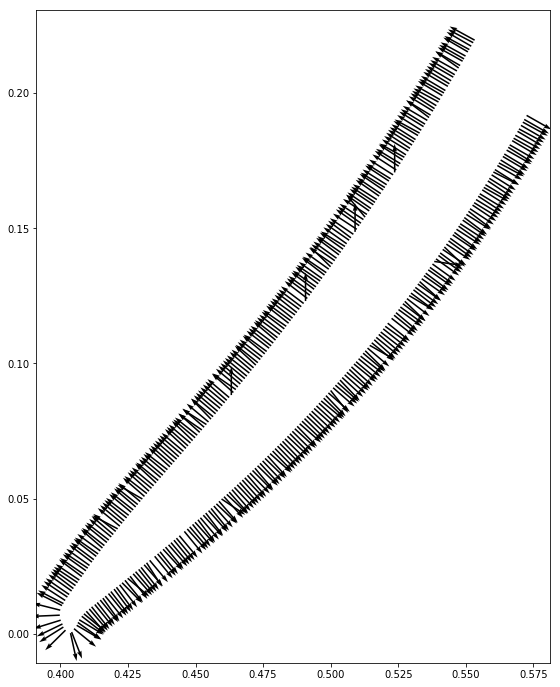

In [168]:
rc('text', usetex=False)

case = plic_collections["bhaga_02_l16"]
centers = case.get_centers()
elements = case.get_plic_elements()
normals = case.get_unit_normals()
tangentials = case.get_unit_tangentials()
u_vec = case.plic_center_velocity()
u_t = case.project_velocity_tangential(vectorial=True)
u_n = case.project_velocity_normal(vectorial=True)

print(np.max(u_vec - u_t - u_n))

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
scale = 0.001
for i, p12 in enumerate(elements[:400]):
    p1, p2 = p12
    #ax.plot([p1[0], p2[0]], [p1[1], p2[1]])
    #ax.scatter(centers[i][0], centers[i][1])
    ax.quiver(centers[i][0], centers[i][1], normals[i][0], normals[i][1], width=0.003)
    #ax.quiver(centers[i][0], centers[i][1], tangentials[i][0], tangentials[i][1], width=0.003)
    #ax.quiver(centers[i][0], centers[i][1], u_n[i][0], u_n[i][1], width=0.003)
    #ax.quiver(centers[i][0], centers[i][1], u_t[i][0], u_t[i][1], width=0.003)
ax.set_aspect('equal')
plt.show()

## Plot tangential velocity as magnitude and componentwise

0.24417884796585676
3.824610138522122
0.6345813404120308
7.879080305375464
15.749256174251585
23.16096768674223


Text(0.5,0,'$\\varphi$')

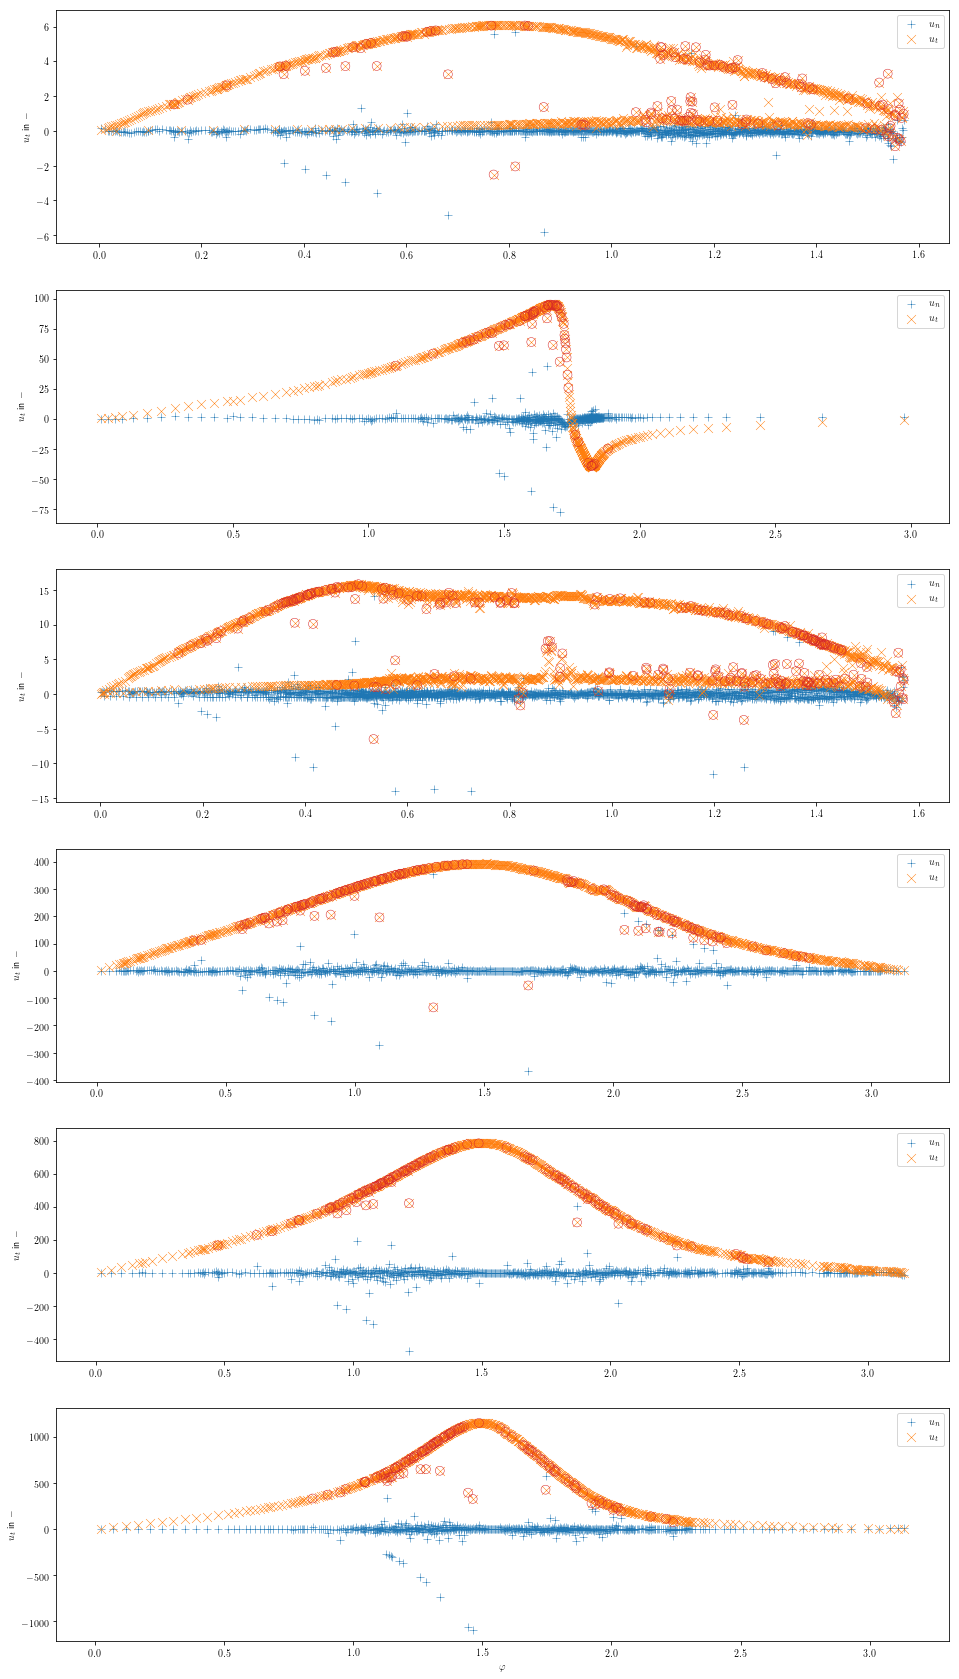

In [304]:
keys = plic_collections.keys()
size = 80
lw = 0.5
u_tol_frac = [0.04, 0.04, 0.04, 0.02, 0.02, 0.02]

fig, axarr = plt.subplots(len(keys), 1, sharex=False, figsize=(16, 5*len(keys)))
for i, case in enumerate(plic_collections.keys()):
    plic = plic_collections[case]
    rad, phi = plic.get_polar_coordinates()
    u_t = plic.project_velocity_tangential(vectorial=False)
    u_t_vec = plic.project_velocity_tangential(vectorial=True)
    u_n = plic.project_velocity_normal(vectorial=False)
    u_n_vec = plic.project_velocity_normal(vectorial=True)
    u_tol = np.amax(np.absolute(u_t)) * u_tol_frac[i]
    print(u_tol)
    outliers = np.linalg.norm(u_n_vec, axis=1) < u_tol
    axarr[i].scatter(phi, u_n, marker="+", color='C0', s=size, lw=lw, label=r"$u_{n}$")
    axarr[i].scatter(phi, u_t, marker="x", color='C1', s=size, lw=lw, label=r"$u_{t}$")
    #axarr[i].scatter(phi, u_t[:,0], marker="*", facecolors='none', edgecolors='C0', s=size, lw=lw, label=r"$u_{tx}$")
    #axarr[i].scatter(phi, u_t[:,1], marker="+", c='C1', s=size, lw=lw, label=r"$u_{ty}$")
    #axarr[i].scatter(phi, np.linalg.norm(u_t, axis=1), marker="<", facecolors='none', edgecolors='C2', s=size, lw=lw, label=r"$|\mathbf{u}_{t}|$")
    axarr[i].scatter(np.ma.masked_array(phi, mask=outliers), np.ma.masked_array(u_t, mask=outliers), marker="o", facecolors='none', edgecolors='C3', s=size, lw=lw)
    #axarr[i].scatter(np.ma.masked_array(phi, mask=outliers), np.ma.masked_array(u_t[:,1], mask=outliers), marker="o", facecolors='none', edgecolors='C3', s=size, lw=lw)
    axarr[i].set_ylabel(r"$u_t$ in $-$")
    #axarr[i].set_xlim(0.0, np.pi)
    axarr[i].legend()
    
axarr[-1].set_xlabel(r"$\varphi$")

## Create surface distance plots for simple shapes

In [201]:
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

class SimpleMLP(torch.nn.Module):
    def __init__(self, n_inputs=1, n_outputs=1, n_layers=1, n_neurons=10, activation=torch.sigmoid):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.activation = activation
        self.layers = torch.nn.ModuleList()
        # input layer to first hidden layer
        self.layers.append(torch.nn.Linear(self.n_inputs, self.n_neurons))
        # add more hidden layers if specified
        if self.n_layers > 1:
            for hidden in range(self.n_layers-1):
                self.layers.append(torch.nn.Linear(self.n_neurons, self.n_neurons))
        # last hidden layer to output layer
        self.layers.append(torch.nn.Linear(self.n_neurons, self.n_outputs))
        
    def forward(self, x):
        for i_layer in range(self.n_layers):
            x = self.activation(self.layers[i_layer](x))
        return self.layers[-1](x)

model_base_path = "../shapes/models/"
shape_models = {}
for key in ["bhaga_03_l16", "water_01_l16", "water_03_l16", "water_05_l16"]:
    model = SimpleMLP(n_layers=6, n_neurons=40, activation=torch.sigmoid)
    model.load_state_dict(torch.load(model_base_path + key + ".pt"))
    shape_models[key] = model

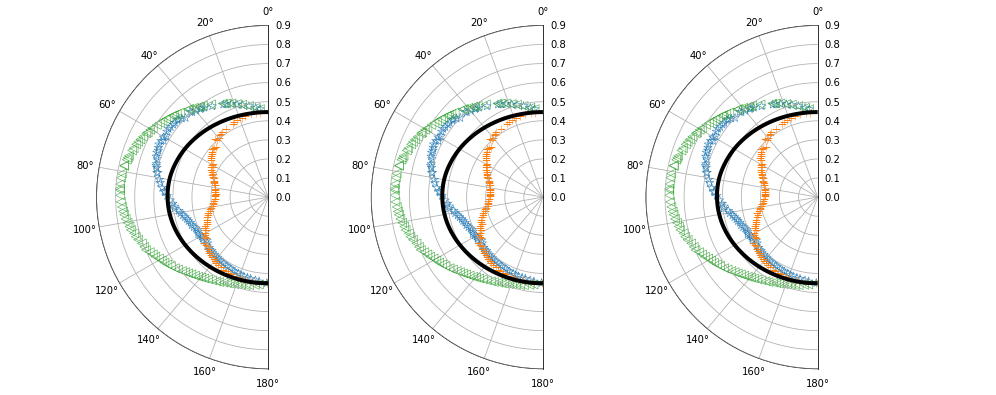

In [50]:
fig, axarr = plt.subplots(1, 3, figsize=(16, 16), subplot_kw=dict(projection='polar'))
fig.subplots_adjust(wspace=-0.2)

lw = 2.0
lew = 0.5
lc = 'k'

def half_axis(ax):
    ax.set_theta_zero_location("N")
    ax.set_xlim(0.0, np.pi)
    ax.set_aspect('equal')
    return ax

def twin_axis(ax):
    ax2 = ax.figure.add_axes(ax.get_position(), projection='polar', 
                             label='twin', frameon=False,
                             theta_direction=ax.get_theta_direction(),
                             theta_offset=ax.get_theta_offset())
    ax2.xaxis.set_visible(False)
    #ax2._r_label_position._t = (22.5 + 180, 0.0)
    #ax2._r_label_position.invalidate()
    #for label in ax.get_yticklabels():
    #    ax.figure.texts.append(label)
    return ax2

# model shape
plot_phi = np.linspace(0.0, np.pi, 100)
phi_tensor = torch.from_numpy(plot_phi).unsqueeze_(-1)
water_01_rad = shape_models["water_01_l16"].forward(phi_tensor).detach().squeeze().numpy()

axarrVel = []
for ax in axarr:
    plic = plic_collections["water_01_l16"]
    rad, phi = plic.get_polar_coordinates()
    rad_model = shape_models["water_01_l16"].forward(torch.from_numpy(phi).unsqueeze_(-1)).detach().squeeze().numpy()
    centers = plic.get_centers()
    ux, uy = plic.fields.get_reynolds(centers[:,0], centers[:,1], relative=True, magnitude=False)
    u_t = plic.project_tangential(np.asarray([ux, uy]).T)
    u_n = plic.project_normal(np.asarray([ux, uy]).T)
    u_tol = np.amax(np.linalg.norm(u_n)) * u_tol_frac
    u_t_scale = u_t / np.amax(np.linalg.norm(u_t))
    u_n_scale = u_n / np.amax(np.linalg.norm(u_t))
    
    ax2 = twin_axis(ax)
    ax = half_axis(ax)
    ax.yaxis.set_visible(False)

    #ax.plot(plot_phi, water_01_rad, ls="-", lw=lw, color=lc)
    ax.set_ylim(0, 0.9)
    # add new axis
    ax2 = half_axis(ax2)
    ax2.scatter(phi[::10], rad_model[::10] + 5*u_t_scale[:,0][::10], marker="*", facecolors='none', edgecolors='C0', s=size, lw=lew)
    ax2.scatter(phi[::10], rad_model[::10] + 5*u_t_scale[:,1][::10], marker="+", c='C1', s=size, lw=lew)
    ax2.scatter(phi[::10], rad_model[::10] + 5*np.linalg.norm(u_t_scale, axis=1)[::10], marker="<", facecolors='none', edgecolors='C2', s=size, lw=lew)
    
    #ax2.plot(plot_phi, 2.0*water_01_rad, ls="--", lw=lw, color='r')
    ax2.set_ylim(0, 0.9)
    axarrVel.append(ax2)
    ax2.plot(plot_phi, water_01_rad, ls="-", lw=4, color=lc)


## Plot effect of outlier removel

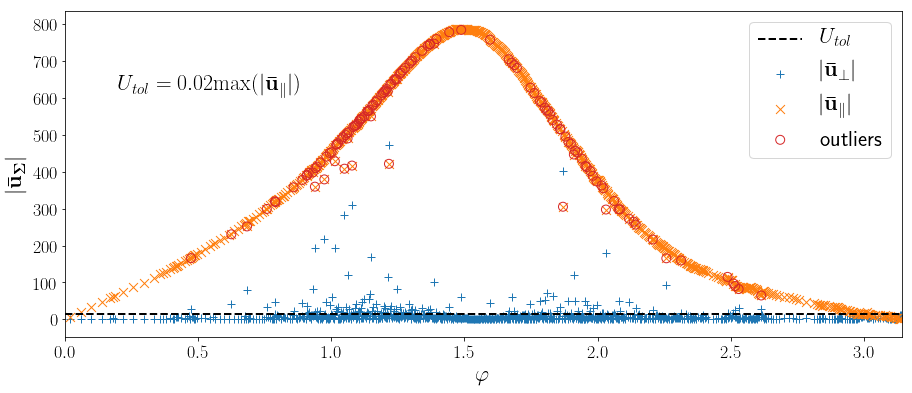

In [260]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15, 6))
lw=1.0
rc('text', usetex=True)

plic = plic_collections["water_03_l16"]
rad, phi = plic.get_polar_coordinates()
mag_u_t = np.linalg.norm(plic.project_velocity_tangential(vectorial=True), axis=1)
mag_u_n = np.linalg.norm(plic.project_velocity_normal(vectorial=True), axis=1)
u_tol = np.amax(mag_u_t) * 0.02
# the criteron is inverted for the masked_array function
outliers = mag_u_n < u_tol

ax.scatter(phi, mag_u_n, marker="+", edgecolors='C0', s=size, lw=lw, label=r"$|\mathbf{\bar{u}_{\bot}}|$")
ax.scatter(phi, mag_u_t, marker="x", edgecolors='C1', s=size, lw=lw, label=r"$|\mathbf{\bar{u}_{\parallel}}|$")

ax.scatter(np.ma.masked_array(phi, mask=outliers), np.ma.masked_array(mag_u_t, mask=outliers),
           marker="o", facecolors='none', edgecolors='C3', s=size, lw=lw, label="outliers")
ax.axhline(u_tol, 0.0, 1.0, ls="--", lw=2, color="k", label=r"$U_{tol}$")

ax.set_xlabel(r"$\varphi$", fontsize=fontsize_labels)
ax.set_xlim(0.0, np.pi)
ax.set_ylabel(r"$|\mathbf{\bar{u}_\Sigma}|$", fontsize=fontsize_labels)
ax.legend(fontsize=fontsize_labels)
ax.tick_params(labelsize=fontsize_ticks)
ax.text(0.2, 600, r"$U_{tol} = 0.02\mathrm{max}(|\mathbf{\bar{u}_{\parallel}}|)$", horizontalalignment='left', verticalalignment='bottom', fontsize=fontsize_labels)
plt.savefig("marked_outliers.pdf", bbox_inches="tight")
plt.savefig("marked_outliers.png", bbox_inches="tight")

## Remove outliers from all simulations

In [404]:
keys = plic_collections.keys()
u_tol_frac = [0.04, 0.04, 0.04, 0.02, 0.02, 0.02]

phi_clean = {}
rad_clean = {}
u_t_clean = {}

for i, case in enumerate(plic_collections.keys()):
    plic = plic_collections[case]
    rad, phi = plic.get_polar_coordinates()
    u_t = plic.project_velocity_tangential(vectorial=False)
    u_n = plic.project_velocity_normal(vectorial=False)
    u_tol = np.amax(np.absolute(u_t)) * u_tol_frac[i]
    outliers = np.absolute(u_n) < u_tol
    phi_clean[case] = phi[outliers.squeeze(axis=1)]
    rad_clean[case] = rad[outliers.squeeze(axis=1)]
    u_t_clean[case] = u_t[outliers]
    print("Marked {} out of {} cells as outlier for case {}.".format(outliers.shape[0]-np.count_nonzero(outliers), u_t.shape[0], case))

Marked 126 out of 1227 cells as outlier for case bhaga_02_l16.
Marked 62 out of 585 cells as outlier for case bhaga_03_l16.
Marked 246 out of 2105 cells as outlier for case bhaga_04_l16.
Marked 153 out of 920 cells as outlier for case water_01_l16.
Marked 126 out of 772 cells as outlier for case water_03_l16.
Marked 107 out of 625 cells as outlier for case water_05_l16.


## Train ML models for velocity profile

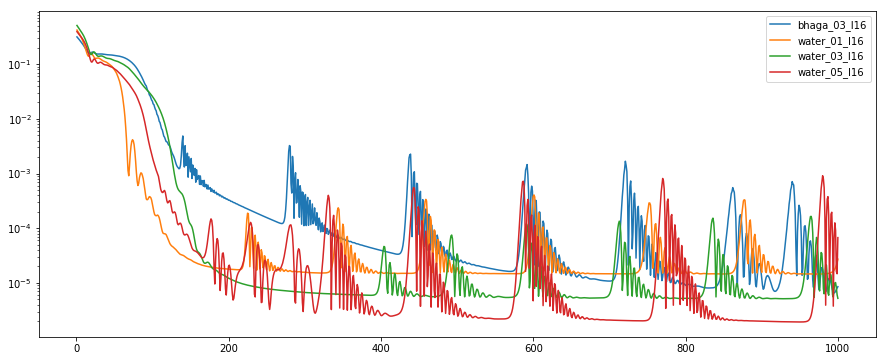

In [233]:
!mkdir -p models

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
rc('text', usetex=False)

for i, case in enumerate(["bhaga_03_l16", "water_01_l16", "water_03_l16", "water_05_l16"]):
    u_t = u_t_clean[case]
    u_t_norm = (u_t - np.min(u_t)) / (np.max(u_t) - np.min(u_t))
    phi_tensor = torch.from_numpy(phi_clean[case]).unsqueeze(-1)
    u_t_tensor = torch.from_numpy(u_t_norm)
    model = SimpleMLP(n_layers=6, n_neurons=60, activation=torch.relu)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
    loss_epochs = []
    best_loss = 1.0E5
    for e in range(1, 1001):
        optimizer.zero_grad()
        output = model.forward(phi_tensor)
        loss = criterion(output.squeeze(dim=1), u_t_tensor)
        loss.backward()
        optimizer.step()
        loss_epochs.append(loss.item())
        if loss_epochs[-1] < best_loss:
            min_loss = loss_epochs[-1]
            torch.save(model.state_dict(), "models/u_t_" + case + "_best.pt")
    ax.plot(range(1, 1001), loss_epochs, label=case)
            
ax.set_yscale('log')
ax.legend()
plt.show()

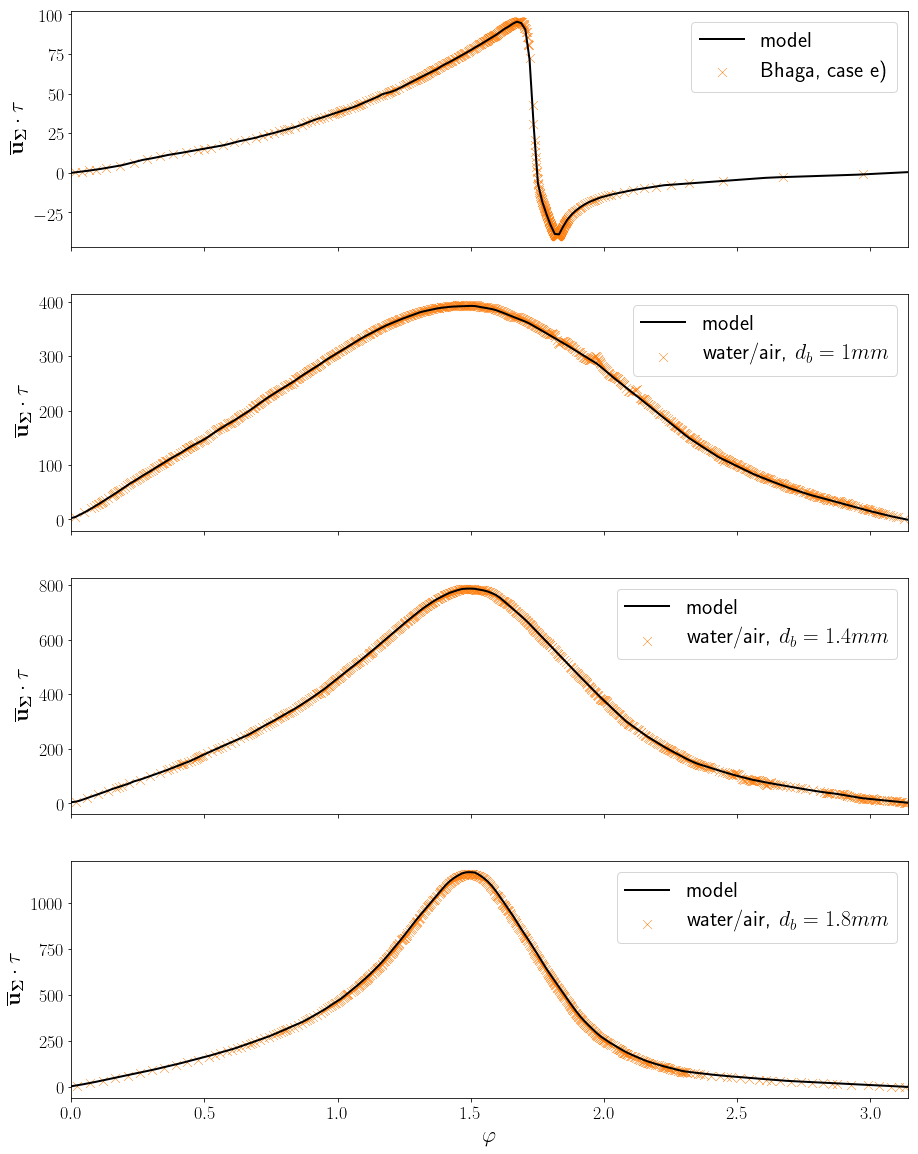

In [280]:
rc('text', usetex=True)
labels = ["Bhaga, case e)", "water/air, $d_b=1mm$", "water/air, $d_b=1.4mm$", "water/air, $d_b=1.8mm$"]

fig, axarr = plt.subplots(4, 1, sharex=True, figsize=(15, 20))
for i, case in enumerate(["bhaga_03_l16", "water_01_l16", "water_03_l16", "water_05_l16"]):
    axarr[i].scatter(phi_clean[case], u_t_clean[case], color="C1", s=80, marker="x", lw=0.5, label=labels[i])
    axarr[i].set_xlim(0.0, np.pi)
    phi_eval = torch.from_numpy(np.linspace(0.0, np.pi, 200)).unsqueeze(-1)
    model = SimpleMLP(n_layers=6, n_neurons=60, activation=torch.relu)
    model.load_state_dict(torch.load("models/u_t_" + case + "_best.pt"))
    u_t_m = model.forward(phi_eval).detach().numpy().squeeze(axis=1)
    u_t_m = u_t_m * (np.max(u_t_clean[case]) - np.min(u_t_clean[case])) + np.min(u_t_clean[case])
    axarr[i].plot(phi_eval.numpy().squeeze(axis=1), u_t_m, color="k", lw=2, label="model")
    axarr[i].legend(fontsize=fontsize_labels)
    axarr[i].set_ylabel(r"$\mathbf{\overline{u}_\Sigma}\cdot \mathbf{\tau}$", fontsize=fontsize_labels)
    axarr[i].tick_params(labelsize=fontsize_ticks)
    
axarr[-1].set_xlabel(r"$\varphi$", fontsize=fontsize_labels)
plt.savefig("u_t_simple.pdf", bbox_inches="tight")
plt.savefig("u_t_simple.png", bbox_inches="tight")

### Split data for inner and outer contour

Case bhaga_02_l16:
Found 412 points on inner contour and 689 points on outer contour (1101 total points).
Case bhaga_04_l16:
Found 835 points on inner contour and 1024 points on outer contour (1859 total points).


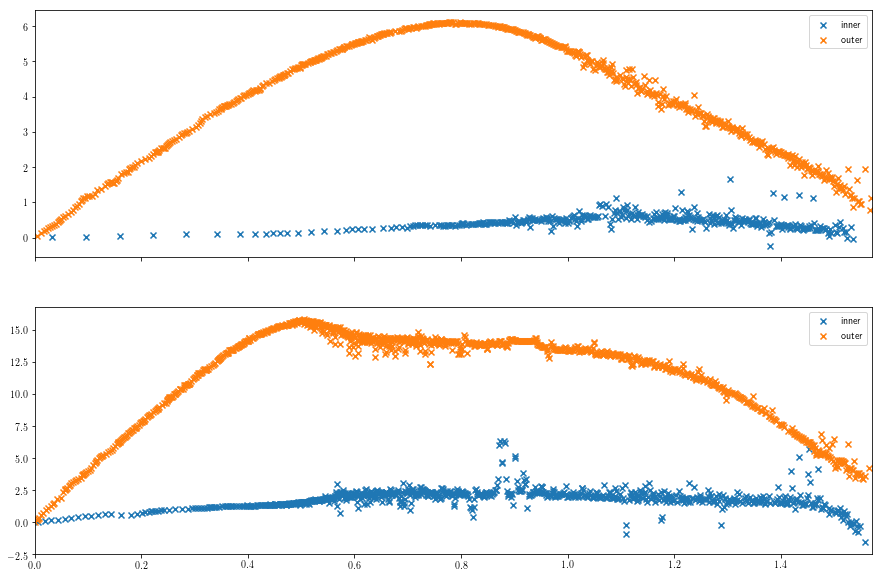

In [405]:
model_base_path = "../shapes/models/"

phi_inout = {}
u_t_inout = {}

fig, axarr = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

for i, case in enumerate(["bhaga_02_l16", "bhaga_04_l16"]):
    phi_tensor = torch.from_numpy(phi_clean[case]).unsqueeze(-1)
    inner_rad = SimpleMLP(n_layers=6, n_neurons=60, activation=torch.sigmoid)
    outer_rad = SimpleMLP(n_layers=6, n_neurons=60, activation=torch.sigmoid)
    inner_rad.load_state_dict(torch.load(model_base_path + case + "_inner.pt"))
    outer_rad.load_state_dict(torch.load(model_base_path + case + "_outer.pt"))
    dist_inner = np.absolute(rad_clean[case] - inner_rad.forward(phi_tensor).detach().numpy().squeeze(axis=1))
    dist_outer = np.absolute(rad_clean[case] - outer_rad.forward(phi_tensor).detach().numpy().squeeze(axis=1))
    inner_contour = dist_inner < dist_outer
    outer_contour = dist_outer < dist_inner
    phi_inout[case + "-inner"] = phi_clean[case][inner_contour]
    phi_inout[case + "-outer"] = phi_clean[case][outer_contour]
    u_t_inout[case + "-inner"] = u_t_clean[case][inner_contour]
    u_t_inout[case + "-outer"] = u_t_clean[case][outer_contour]
    print("Case {}:".format(case))
    print("Found {} points on inner contour and {} points on outer contour ({} total points).".format(
    phi_inout[case + "-inner"].shape[0], phi_inout[case + "-outer"].shape[0], phi_inout[case + "-inner"].shape[0] + phi_inout[case + "-outer"].shape[0]))
    axarr[i].scatter(phi_inout[case + "-inner"], u_t_inout[case + "-inner"], marker="x", label="inner")
    axarr[i].scatter(phi_inout[case + "-outer"], u_t_inout[case + "-outer"], marker="x", label="outer")
    axarr[i].legend()
    axarr[i].set_xlim(0, 0.5*np.pi)

bhaga_02_l16-inner tensor([0.1199])
bhaga_02_l16-outer tensor([-0.0064])
bhaga_04_l16-inner tensor([0.1986])
bhaga_04_l16-outer tensor([-0.0027])


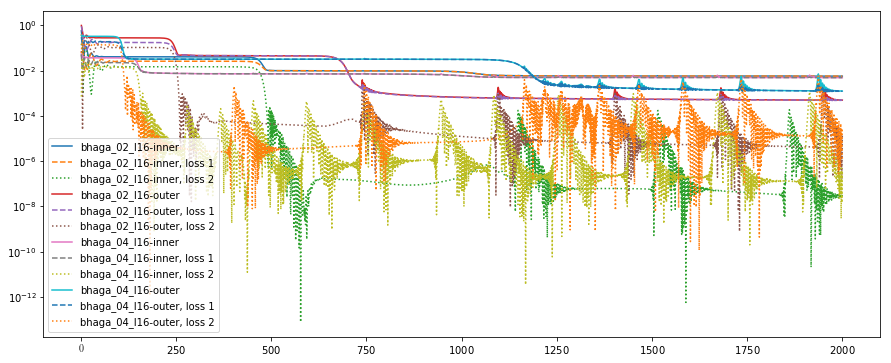

In [406]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
rc('text', usetex=False)

epochs = 2000

for i, case in enumerate(phi_inout.keys()):
    u_t = u_t_inout[case]
    u_t_norm = (u_t - np.min(u_t)) / (np.max(u_t) - np.min(u_t))
    u_t_tensor = torch.from_numpy(u_t_norm)
    phi_tensor = torch.from_numpy(phi_inout[case]).unsqueeze(-1)
    phi90 = torch.ones(1,1) * np.pi * 0.5
    u_t90 = torch.ones(1) * (0.0 - np.min(u_t)) / (np.max(u_t) - np.min(u_t))
    print(case, u_t90)
    model = SimpleMLP(n_layers=6, n_neurons=80, activation=torch.sigmoid)
    criterion_1 = torch.nn.MSELoss()
    criterion_2 = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
    loss_epochs = []
    loss_1_epochs = []
    loss_2_epochs = []
    best_loss = 1.0E5
    for e in range(1, epochs + 1):
        optimizer.zero_grad()
        output = model.forward(phi_tensor)
        output_phi90 = model.forward(phi90)
        loss_1 = criterion_1(output.squeeze(dim=1), u_t_tensor)
        loss_2 = criterion_2(output_phi90.squeeze(dim=1), u_t90)
        loss = loss_1 + loss_2
        loss.backward()
        optimizer.step()
        loss_epochs.append(loss.item())
        loss_1_epochs.append(loss_1.item())
        loss_2_epochs.append(loss_2.item())
        if loss_epochs[-1] < best_loss:
            min_loss = loss_epochs[-1]
            torch.save(model.state_dict(), "models/u_t_" + case + ".pt")
    ax.plot(range(1, epochs + 1), loss_epochs, label=case)
    ax.plot(range(1, epochs + 1), loss_1_epochs, ls="--", label=case + ", loss 1")
    ax.plot(range(1, epochs + 1), loss_2_epochs, ls=":", label=case + ", loss 2")
            
ax.set_yscale('log')
ax.legend()
plt.show()

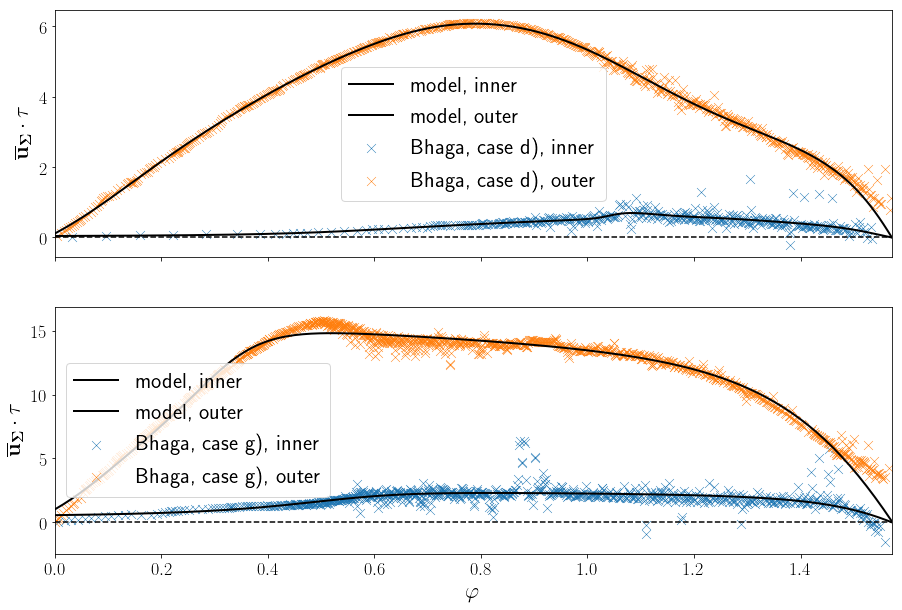

In [408]:
rc('text', usetex=True)
labels = ["Bhaga, case d)", "Bhaga, case g)"]

fig, axarr = plt.subplots(2, 1, sharex=True, figsize=(15, 10))
for i, case in enumerate(["bhaga_02_l16", "bhaga_04_l16"]):
    axarr[i].scatter(phi_inout[case + "-inner"], u_t_inout[case + "-inner"], s=80, marker="x", lw=0.5, label=labels[i] + ", inner")
    axarr[i].scatter(phi_inout[case + "-outer"], u_t_inout[case + "-outer"], s=80, marker="x", lw=0.5, label=labels[i] + ", outer")
    axarr[i].set_xlim(0.0, np.pi/2)
    phi_tensor = torch.from_numpy(np.linspace(0.0, 0.5*np.pi, 200)).unsqueeze(-1)
    inner_model = SimpleMLP(n_layers=6, n_neurons=80, activation=torch.sigmoid)
    outer_model = SimpleMLP(n_layers=6, n_neurons=80, activation=torch.sigmoid)
    inner_model.load_state_dict(torch.load("models/u_t_" + case + "-inner.pt"))
    outer_model.load_state_dict(torch.load("models/u_t_" + case + "-outer.pt"))
    u_t_in = inner_model.forward(phi_tensor).detach().numpy().squeeze(axis=1)
    u_t_out = outer_model.forward(phi_tensor).detach().numpy().squeeze(axis=1)
    u_t_in = u_t_in * (np.max(u_t_inout[case + "-inner"]) - np.min(u_t_inout[case + "-inner"])) + np.min(u_t_inout[case + "-inner"])
    u_t_out = u_t_out * (np.max(u_t_inout[case + "-outer"]) - np.min(u_t_inout[case + "-outer"])) + np.min(u_t_inout[case + "-outer"])
    axarr[i].plot(phi_tensor.numpy(), u_t_in, color="k", lw=2, label="model, inner")
    axarr[i].plot(phi_tensor.numpy(), u_t_out, color="k", lw=2, label="model, outer")
    axarr[i].legend(fontsize=fontsize_labels)
    axarr[i].set_ylabel(r"$\mathbf{\overline{u}_\Sigma}\cdot \mathbf{\tau}$", fontsize=fontsize_labels)
    axarr[i].tick_params(labelsize=fontsize_ticks)
    axarr[i].axhline(0.0, 0.0, 1.0, ls="--", c="k")
    
axarr[-1].set_xlabel(r"$\varphi$", fontsize=fontsize_labels)
plt.savefig("u_t_complex.pdf", bbox_inches="tight")
plt.savefig("u_t_complex.png", bbox_inches="tight")